<a href="https://colab.research.google.com/github/dyvanoff/diplo-datos-ayvd-g3/blob/master/practico_analisisDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [0]:
%pylab inline
import pandas as pd
import seaborn as sns
import scipy as sp
sns.set(style='ticks', color_codes=True)
sns.set_context(context='talk', font_scale=1.2)

#Definimos colores
BLUE = '#35A7FF'
RED = '#FF5964'

#Imprimimos las versiones de los paquetes
from platform import python_version
print('Python    :', python_version())
print('Numpy     :', np.__version__)
print('MatPlotLib:', matplotlib.__version__)
print('Pandas    :', pd.__version__)
print('Seaborn   :', sns.__version__)
print('SciPy     :', sp.__version__)

Populating the interactive namespace from numpy and matplotlib
Python    : 3.6.9
Numpy     : 1.18.5
MatPlotLib: 3.2.1
Pandas    : 1.0.4
Seaborn   : 0.10.1
SciPy     : 1.4.1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [0]:
#Leemos el archivo
dataset = pd.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
print('Tamaño del dataset:', dataset.shape)

Tamaño del dataset: (1620, 120)


In [0]:
#Vemos las columnas
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [0]:
#Definimos y seleccionamos las columnas que queremos analizar
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [0]:
#Reimprimimos el dataset con las columnas seleccionadas
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,-,10,10,10,10,10,9.29,7,8.18,6,8.73,4
1616,2008,DNK,Denmark,Western Europe,-,10,10,10,10,10,9.49,3,7.98,9,8.73,4
1617,2008,CHE,Switzerland,Western Europe,-,10,10,10,10,10,9.31,6,8.35,4,8.83,3
1618,2008,NZL,New Zealand,Oceania,-,10,10,10,10,10,9.42,4,8.46,3,8.94,2


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [0]:
#Vemos los tipos de variables en el dataset por columna
dataset.dtypes

year                                  int64
ISO_code                             object
countries                            object
region                               object
hf_score                             object
                                      ...  
ef_regulation_business_compliance    object
ef_regulation_business               object
ef_regulation                        object
ef_score                             object
ef_rank                              object
Length: 120, dtype: object

In [0]:
#Redefinimos los tipos y reemplazamos "-" por "np.nan"
dataset = dataset[important_cols].replace('-', np.nan)
for score_col in score_cols:
    dataset[score_col] = pd.to_numeric(dataset[score_col])
dataset

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,2008,AUS,Australia,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.29,7.0,8.18,6.0,8.73,4.0
1616,2008,DNK,Denmark,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.49,3.0,7.98,9.0,8.73,4.0
1617,2008,CHE,Switzerland,Western Europe,NaN,10.0,10.0,10.0,10.0,10.0,9.31,6.0,8.35,4.0,8.83,3.0
1618,2008,NZL,New Zealand,Oceania,NaN,10.0,10.0,10.0,10.0,10.0,9.42,4.0,8.46,3.0,8.94,2.0


In [0]:
#Revemos los tipos de datos
dataset.dtypes

year                        int64
ISO_code                   object
countries                  object
region                     object
pf_identity_legal         float64
pf_identity_sex_male      float64
pf_identity_sex_female    float64
pf_identity_sex           float64
pf_identity_divorce       float64
pf_identity               float64
pf_score                  float64
pf_rank                   float64
ef_score                  float64
ef_rank                   float64
hf_score                  float64
hf_rank                   float64
dtype: object

# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  3. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 
  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.
  3. ¿Tiene sentido calcular la moda?
  4. ¿Cómo pueden sanearse los valores faltantes?
  5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  
  

**1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.**

Primero hacemos uso de la tarea "*describe()*" de *pandas* que nos proporciona informacion del set de datos sobre las variables numéricas; como cuentas, media, máximos y mimínos entre otras, sobre las columnas.

In [0]:
#Resumen
dataset.describe()

,year,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
count,1620.000000,308.000000,1537.000000,1540.000000,1540.000000,1519.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000
mean,2012.500000,6.379870,6.701366,7.922078,7.314935,7.485188,7.280649,7.163409,77.671429,6.792981,77.420779,6.978214,77.465584
std,2.873168,3.640415,4.685828,4.038529,4.056317,3.502156,3.181577,1.392409,44.757695,0.906827,44.776169,1.056239,44.782074
min,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000,1.000000,2.580000,1.000000,3.690000,1.000000
25%,2010.000000,7.000000,0.000000,10.000000,5.000000,5.000000,5.000000,6.147500,39.000000,6.220000,39.000000,6.280000,39.000000
50%,2012.500000,7.000000,10.000000,10.000000,10.000000,10.000000,8.800000,7.145000,77.500000,6.880000,77.000000,6.900000,77.000000
75%,2015.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.380000,116.000000,7.440000,116.000000,7.880000,116.000000
max,2017.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.560000,162.000000,9.110000,162.000000,9.120000,162.000000


Sobre la tabla desplegada, podemos observar que tenemos una columna temporal (*año*), 14 de puntajes y 3 de posiciones (*rank*).

Presentamos el rango de las variables (numéricas):

In [0]:
print ('Dimensión de los datos (Filas, Columnas): (%i,%i)' %(dataset.shape[1], dataset.shape[0]))
for important_col in dataset.columns:
    if (dataset[important_col].dtypes == 'float64'):
        print(important_col+': [%.2f,%.2f]' %(min(dataset[important_col]), max(dataset[important_col])))
        continue
    if (dataset[important_col].dtypes == 'int64'):
        print(important_col+': [%i,%i]' %(min(dataset[important_col]), max(dataset[important_col])))

Dimensión de los datos (Filas, Columnas): (16,1620)
year: [2008,2017]
pf_identity_legal: [0.00,10.00]
pf_identity_sex_male: [0.00,10.00]
pf_identity_sex_female: [0.00,10.00]
pf_identity_sex: [0.00,10.00]
pf_identity_divorce: [0.00,10.00]
pf_identity: [0.00,10.00]
pf_score: [2.22,9.56]
pf_rank: [1.00,162.00]
ef_score: [2.58,9.11]
ef_rank: [1.00,162.00]
hf_score: [3.69,9.12]
hf_rank: [1.00,162.00]


**2.Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana?**

Luego de un intenso debate, llegamos a la conclusón de que para responder a esta pregunta es escencial saber o definir con mas precision, **qué es** lo que se quiere comparar entre países, ya que tenemos varias realizaciones, en funcion del tiempo, de las variables en cuestion. 

En caso de querer comparar valores históricos (es decir, sobre todo el rango de años), optaríamos por comparar entre los valores de las **medianas**, ya que no están influenciadas por los valores extremos.. Esta desición se basó en una previa y rapida inspección de la distribución de los datos en función del tiempo. 

Sin embargo la comparación entre estos valores *no* nos dice si un país actualmente esta "*mejor*" que otro. En caso de querer comparar la actualidad de 2 países, tomariamos solo los valores del **último año (2017)**; y si la información que queremos obtener es una suerte de "*predicción*" a futuro, se podría analizar la **pendiente** por ejemplo, a partir de datos de los ultimos tres años.

**3. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.**

A continuación estudiaremos el dataset, removiendo las filas con NaNs.

In [0]:
#Creamos máscaras para los NaNs
pf_id_no_nan = ~dataset.pf_identity.isna() #Máscara para no contabilizar los NAN en pd_id
hf_sc_no_nan = ~dataset.hf_score.isna()    #Máscara para no contabilizar los NAN en hf_sc

#Luego de analizarlas, vemos que ambas máscaras son iguales.
#Esto se debe a que hf_score depende de pf_identity, por lo tanto si la segunda es NaN, la primera también lo es.
(print('[hf_sc_no_nan] y [pf_id_no_nan] son iguales')) if pd.Series.equals(hf_sc_no_nan,pf_id_no_nan) else (print('[hf_sc_no_nan] y [pf_id_no_nan] son distintos'))

#Máscara para LatAmyC
LatAmyC = dataset.region == 'Latin America & the Caribbean'

#Creamos una columna nueva diferenciando LatAmyC del Resto del mundo
#También creamos una columna que todos tengan igual (esto sirve para el futuro)
dataset['lugar']              = 'Resto'                    
dataset.loc[LatAmyC, 'lugar'] = 'LatAmyC'
dataset['Todos']              = 'Individuales'  

#New Dataset sin NaNs
datasetNew = dataset[pf_id_no_nan]

#New máscara para LatAmyC
LatAmyCnew = datasetNew.lugar == 'LatAmyC'
print(dataset.shape, datasetNew.shape)

[hf_sc_no_nan] y [pf_id_no_nan] son iguales
(1620, 18) (1540, 18)


De aquí en adelante trabajamos con el dataset sin NaNs (a menos se indique lo contrario).

Calculamos los estadísticos *media*, *mediana* y la *dispersión* de **pf_identity** y **hf_score** del nuevo dataset.

In [0]:
print ('Nueva dimensión de los datos (filas, columnas): (%i,%i)' %(datasetNew.shape[1], datasetNew.shape[0]))

#Imprimimos la Media, Mediana y DesvEst de las variables.
print('')
print('Personal Identity Freedom (pf_identity)')
print('Mundo \n Media  : %.2f \n Mediana: %.2f \n DesvEst: %.2f'
      %(np.mean(datasetNew.pf_identity), np.median(datasetNew.pf_identity), np.std(datasetNew.pf_identity)))
print('LatAm y el Caribe \n Media  : %.2f \n Mediana: %.2f \n DesvEst: %.2f'
      %(np.mean(datasetNew.pf_identity[LatAmyCnew]), np.median(datasetNew.pf_identity[LatAmyCnew]), np.std(datasetNew.pf_identity[LatAmyCnew])))
print('')
print('Human Freedom (hf_score)')
print('Mundo \n Media  : %.2f \n Mediana: %.2f \n DesvEst: %.2f'
      %(np.mean(datasetNew.hf_score), np.median(datasetNew.hf_score), np.std(datasetNew.hf_score)))
print('LatAm y el Caribe \n Media  : %.2f \n Mediana: %.2f \n DesvEst: %.2f'
      %(np.mean(datasetNew.hf_score[LatAmyCnew]), np.median(datasetNew.hf_score[LatAmyCnew]), np.std(datasetNew.hf_score[LatAmyCnew])))

Nueva dimensión de los datos (filas, columnas): (18,1540)

Personal Identity Freedom (pf_identity)
Mundo 
 Media  : 7.28 
 Mediana: 8.80 
 DesvEst: 3.18
LatAm y el Caribe 
 Media  : 8.58 
 Mediana: 10.00 
 DesvEst: 1.87

Human Freedom (hf_score)
Mundo 
 Media  : 6.98 
 Mediana: 6.90 
 DesvEst: 1.06
LatAm y el Caribe 
 Media  : 7.04 
 Mediana: 7.02 
 DesvEst: 0.63


A partir de la tabla mostrada arriba, podemos observar que para la variable **Human Freedom**, los valores obtenidos (tanto de las medias como las medianas) de *LatAm y el Caribe* y el *Mundo* son muy similares, y las diferencias se encuentran dentro de los errores. Por ello, no podemos concluir, por lo menos a partir de estos estadísticos, que *LatAm y el Caribe* está "mejor" o "peor" en relación a los valores obtenidos para el *Mundo* en conjunto.

En cuanto a los valores obtenidos para la variable **Personal Identity Freedom**, podemos notar una aprecialble diferencia entre el valor de la *media* y la *mediana* (tanto de *LatAm y el Caribe* como de el *Mundo* en total), lo cual nos da un indicio de presencia de distribuciones asimétricas.
Debido a esto (y a lo expuesto en el **punto 1**), es más conveniente utilzar la *mediana* como valor de comparación. Sin embargo al realizarla, se obtiene que *LatAm y el Caribe* **a priori** se encuentra "mejor" el *Mundo* en total; pero creemos que aún el análisis realizado no es lo suficientemente profundo como para asegurar esta idea.

Analizamos los valores de Human freedom y Identity freedom de *LatAm y el Caribe* y todo el Mundo en funcion de los años.




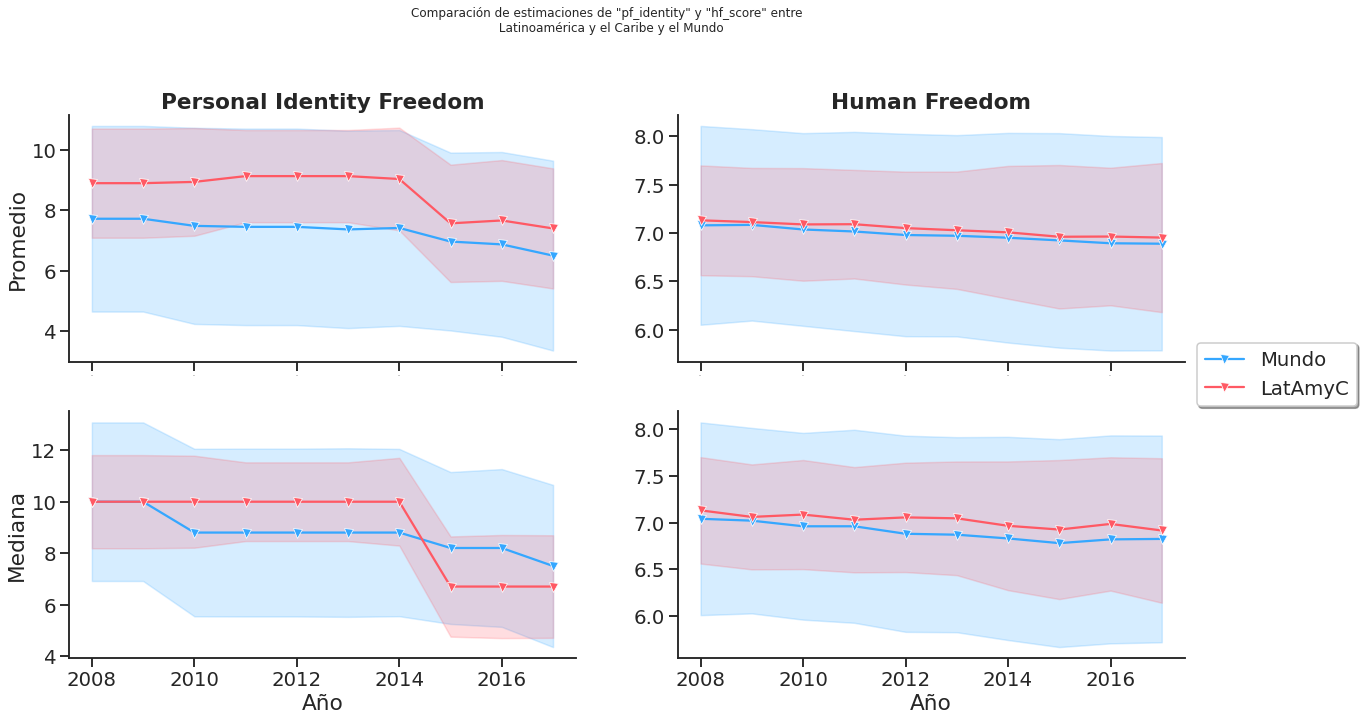

In [0]:
plt.figure(figsize=(20,10))

plt.suptitle('Comparación de estimaciones de "pf_identity" y "hf_score" entre \n Latinoamérica y el Caribe y el Mundo', y=1.03)

plt.subplot(2,2,1)
plt.title('Personal Identity Freedom', weight='bold')
sns.lineplot(data=datasetNew, 
             estimator=np.mean, x='year', y='pf_identity', ci='sd', style='Todos', markers='v', legend=None, color=BLUE)
sns.lineplot(data=datasetNew[LatAmyCnew], 
             estimator=np.mean, x='year', y='pf_identity', ci='sd', style='Todos', markers='v', legend=None, color=RED)
plt.xlabel('')
plt.ylabel('Promedio')
plt.xticks(fontsize=0)
sns.despine()

plt.subplot(2,2,2)
plt.title('Human Freedom', weight='bold')
sns.lineplot(data=datasetNew, 
             estimator=np.mean, x='year', y='hf_score', ci='sd', label='Mundo'  , style='Todos', markers='v', legend=None, color=BLUE)
sns.lineplot(data=datasetNew[LatAmyCnew], 
             estimator=np.mean, x='year', y='hf_score', ci='sd', label='LatAmyC', style='Todos', markers='v', legend=None, color=RED)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=0)
sns.despine()

plt.legend(bbox_to_anchor=(1.3, -0.1), loc=4, borderaxespad=-1, shadow=True)

plt.subplot(2,2,3)
sns.lineplot(data=datasetNew,
             estimator=np.median, x='year', y='pf_identity', ci='sd', style='Todos', markers='v', legend=None, color=BLUE)
sns.lineplot(data=datasetNew[LatAmyCnew],
             estimator=np.median, x='year', y='pf_identity', ci='sd', style='Todos', markers='v', legend=None, color=RED)
plt.xlabel('Año')
plt.ylabel('Mediana')
sns.despine()

plt.subplot(2,2,4)
sns.lineplot(data=datasetNew,
             estimator=np.median, x='year', y='hf_score', ci='sd', style='Todos', markers='v', legend=None, color=BLUE)
sns.lineplot(data=datasetNew[LatAmyCnew],
             estimator=np.median, x='year', y='hf_score', ci='sd', style='Todos', markers='v', legend=None, color=RED)
plt.xlabel('Año')
plt.ylabel('')
sns.despine()

plt.show()

A partir de los graficos, en particular para la variable **Personal Identity Freedom**, podemos observar que tanto la *media* como la *mediana* de *LatAm y el Caribe* sufren una abrupta y considerable 
disminución de su valor a partir del 2014. 
Por otro lado, para el *Mundo* presentan un comportamiento menos abruptamente variable, pero aun asi, con una disminucion de los valores a través del tiempo. 

Por otro lado, la variable **Human Freedom** presenta un comportamiento, tanto para la región de *LatAm y el Caribe* como para el *Mundo*,  de valores mucho mas estables en el trascurso del tiempo.

Es importante notar la gran amplitud de las regiones de error (Desvío Estándar) en todas los valores calculados del gráfico.

En este punto cabe destacar de los gráficos que, en contraposición a lo declarado en el *punto 2*, se puede apreciar que el valor de la *mediana* de *LatAm y el Caribe* ha sido menor al de *Mundo* para los últimos 3 años.

**4.¿Tiene sentido calcular la moda?**

Dado que la moda es el valor con mayor frecuencia en una de las distribuciones de datos, en este caso, y apartir de la inpección de las graficas del **punto 3** creemos que no estaría aportando nueva información y no reflejaría la situacion actual de la region de *LatAm y el Caribe* con respecto al *Mundo*.  

**5.¿Cómo pueden sanearse los valores faltantes?**

En nuestro caso, el tratamiento de los valores faltantes en la variable (*NaNs*) fue a partir de la *eliminación completa de la fila*. 
Es decir que, si en alguna de las columnas **pf_identity** o **hf_score** hallábamos *NaN*,descartábamos toda la información brindada por esa fila. 
Cabe mencionar que  **Human Freedom Score** depende del parametro **Personal Freedom Score**, el cual depende del parámetro **Personal Identity Freedom**; por lo cual si hay valores faltantes (*NaN*) en **Personal Identity Freedom** tambien los habría en **Human Freedom Score**.

Otra forma posible de tratar los valores faltantes es intentar rellenarlos (completarlos) a partir de una *interpolacion* (ejemplo: *media*, *mediana*, entre otros) de datos existentes.


**6.¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos?**

Para detectar los outliers decidimos utilizar la función *clean_outliers* (implementada abajo). La misma define como outliers a las realizaciones de los datos cuyo valor cumple que **(x > 1.5**$\times$**IQR + Q3)** o **(x < 1.5**$\times$**IQR - Q1)**, donde **IQR=Q3-Q1**.

In [0]:
#Función para remover outliers más allá de whis*(Q3-Q1).
def clean_outliers(dataset, column_name, whis=1.5):
    """Returns dataset removing the outlier rows from column @column_name."""
    interesting_col = dataset[column_name]
    # Here we can remove the outliers from both ends, or even add more restrictions.
    Q1 = np.quantile(interesting_col, 0.25, interpolation='midpoint')
    Q3 = np.quantile(interesting_col, 0.75, interpolation='midpoint')
    mask_variable_outlier = ((interesting_col <= Q3 + whis*(Q3-Q1))
                            &
                             (Q1 - whis*(Q3-Q1) <= interesting_col))
    return dataset[mask_variable_outlier]

A continuación se muestra el número de outliers de **Human Freedom** e **Personal Identity Freedom** en todo el rango de los años, y luego por separado año a año. 

In [0]:
#Vemos cuántos outliers presentan pf_identity y hf_score juntando todos los años
Out_Glo_pf = len(datasetNew) - len(clean_outliers(datasetNew, 'pf_identity'))
Out_Glo_hf = len(datasetNew) - len(clean_outliers(datasetNew, 'hf_score'))
print('Todos los años juntos (2008 a 2017)'
      '\n Outliers de pf_indentity: %2i == %2.2f %% del total'
      '\n Outliers de hf_score    : %2i == %2.2f %% del total' 
    %(Out_Glo_pf, Out_Glo_pf*100/float(len(datasetNew)),
      Out_Glo_hf, Out_Glo_hf*100/float(len(datasetNew))))
print('')

#Un vistazo a la cantidad de outliers por año
for i in range(min(datasetNew.year), max(datasetNew.year)+1, 1):
    MYI = (datasetNew.year == i)
    Out_Glo_pf_MIY = len(datasetNew[MYI]) - len(clean_outliers(datasetNew[MYI],'pf_identity'))
    Out_Glo_hf_MIY = len(datasetNew[MYI]) - len(clean_outliers(datasetNew[MYI], 'hf_score'))
    print('Año %i'
          '\n Outliers de pf_indentity: %2i == %2.2f %% del total'
          '\n Outliers de hf_score    : %2i == %2.2f %% del total' 
          %(i,
            Out_Glo_pf_MIY, Out_Glo_pf_MIY*100/float(len(datasetNew[MYI])),
            Out_Glo_hf_MIY, Out_Glo_hf_MIY*100/float(len(datasetNew[MYI]))))

Todos los años juntos (2008 a 2017)
 Outliers de pf_indentity:  0 == 0.00 % del total
 Outliers de hf_score    :  5 == 0.32 % del total

Año 2008
 Outliers de pf_indentity:  8 == 5.67 % del total
 Outliers de hf_score    :  0 == 0.00 % del total
Año 2009
 Outliers de pf_indentity:  8 == 5.67 % del total
 Outliers de hf_score    :  0 == 0.00 % del total
Año 2010
 Outliers de pf_indentity:  0 == 0.00 % del total
 Outliers de hf_score    :  0 == 0.00 % del total
Año 2011
 Outliers de pf_indentity:  0 == 0.00 % del total
 Outliers de hf_score    :  0 == 0.00 % del total
Año 2012
 Outliers de pf_indentity:  0 == 0.00 % del total
 Outliers de hf_score    :  0 == 0.00 % del total
Año 2013
 Outliers de pf_indentity:  0 == 0.00 % del total
 Outliers de hf_score    :  1 == 0.64 % del total
Año 2014
 Outliers de pf_indentity:  0 == 0.00 % del total
 Outliers de hf_score    :  0 == 0.00 % del total
Año 2015
 Outliers de pf_indentity:  0 == 0.00 % del total
 Outliers de hf_score    :  0 == 0.00 % d

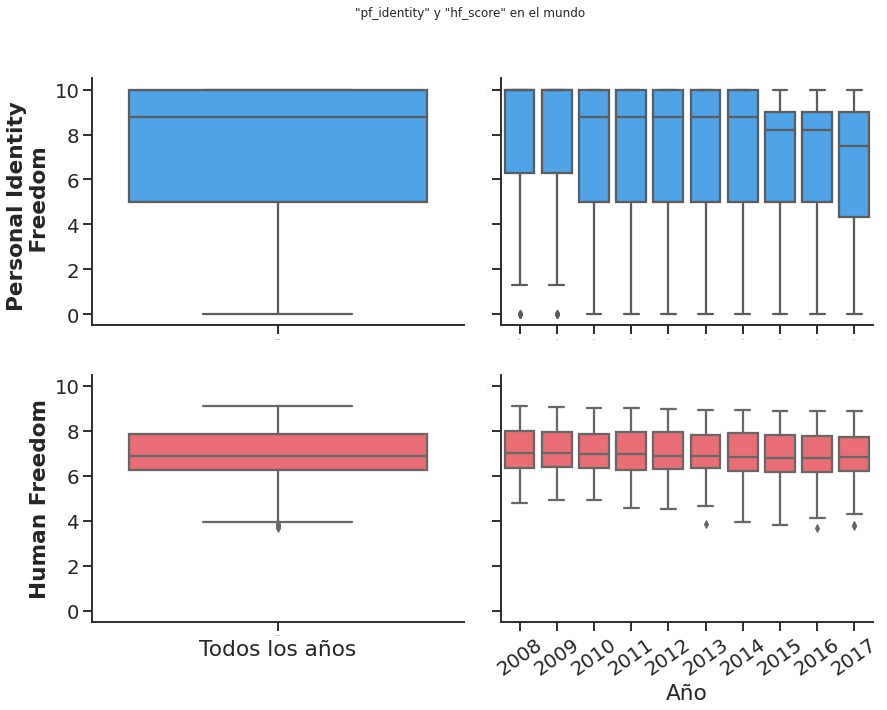

In [0]:
plt.figure(figsize=(14,10))

plt.suptitle('"pf_identity" y "hf_score" en el mundo')
plt.subplots_adjust(wspace=0.1)

plt.subplot(2,2,1)
sns.boxplot(data=datasetNew,x='Todos', y='pf_identity', color=BLUE)
plt.xticks(fontsize=0)
plt.xlabel('')
plt.ylabel('Personal Identity \n Freedom', weight='bold')
plt.ylim(-0.5,10.5)
sns.despine()

plt.subplot(2,2,2)
sns.boxplot(data=datasetNew,x='year', y='pf_identity', color=BLUE)
plt.xlabel('')
plt.ylabel('')
plt.ylim(-0.5,10.5)
plt.yticks(fontsize=0)
plt.xticks(fontsize=0)
sns.despine()

plt.subplot(2,2,3)
sns.boxplot(data=datasetNew,x='Todos', y='hf_score', color=RED)
plt.xticks(fontsize=0)
plt.ylabel('Human Freedom', weight='bold')
plt.xlabel('Todos los años')

plt.ylim(-0.5,10.5)
sns.despine()



plt.subplot(2,2,4)
sns.boxplot(data=datasetNew,x='year', y='hf_score', color=RED)
plt.xlabel('Año')
plt.ylabel('')
plt.xticks(rotation=35)
plt.yticks(fontsize=0)
plt.ylim(-0.5,10.5)
sns.despine()

plt.show()

En el plot anterior, se pueden distinguir los **outliers** (diamantes debajo del blox-plot inferior izquierdo) de *hf_score* considerando todos los años juntos a nivel **global**. El total de outliers calculados es 5 (0.32%) para esta variable.
Por otro lado, no se observan outliers a nivel global al considerar todos años juntos.

En cuanto a los valores discriminados por año, se presentan 8 (5.67%) outliers de *pf_identity* en los 2 primeros años, y menos de 2 (< 1.23%) outliers de *hf_score* en 3 de los últimos 5 años.

A continuación analizamos si la presencia de outliers se encuentran de forma homogenea a través de las regiones o si se agrupan en regiones especificas.

In [0]:
print('Outliers de pf_identity y hf_score por Región')
for Region in datasetNew.region.unique():
    Cant_Reg   = len((np.where(datasetNew.region == Region))[0])
    Out_Reg_pf = len(datasetNew[datasetNew.region == Region]) - len(clean_outliers(datasetNew[datasetNew.region == Region], 'pf_identity'))
    Out_Reg_hf = len(datasetNew[datasetNew.region == Region]) - len(clean_outliers(datasetNew[datasetNew.region == Region], 'hf_score'))
    print('')
    print('%s' 
            '\n Cantidad de países      : %i'
            '\n Outliers de pf_identity : %2i == %2.2f %% del total' 
            '\n Outliers de hf_score    : %2i == %2.2f %% del total' 
            %(Region, 
              Cant_Reg, 
              Out_Reg_pf, Out_Reg_pf*100/float(Cant_Reg),
              Out_Reg_hf, Out_Reg_hf*100/float(Cant_Reg)))

Outliers de pf_identity y hf_score por Región

Eastern Europe
 Cantidad de países      : 212
 Outliers de pf_identity :  5 == 2.36 % del total
 Outliers de hf_score    :  5 == 2.36 % del total

Middle East & North Africa
 Cantidad de países      : 169
 Outliers de pf_identity : 16 == 9.47 % del total
 Outliers de hf_score    :  0 == 0.00 % del total

Sub-Saharan Africa
 Cantidad de países      : 390
 Outliers de pf_identity :  0 == 0.00 % del total
 Outliers de hf_score    :  2 == 0.51 % del total

Latin America & the Caribbean
 Cantidad de países      : 258
 Outliers de pf_identity :  0 == 0.00 % del total
 Outliers de hf_score    : 10 == 3.88 % del total

Caucasus & Central Asia
 Cantidad de países      : 58
 Outliers de pf_identity : 15 == 25.86 % del total
 Outliers de hf_score    :  0 == 0.00 % del total

Oceania
 Cantidad de países      : 40
 Outliers de pf_identity :  1 == 2.50 % del total
 Outliers de hf_score    :  0 == 0.00 % del total

Western Europe
 Cantidad de países     

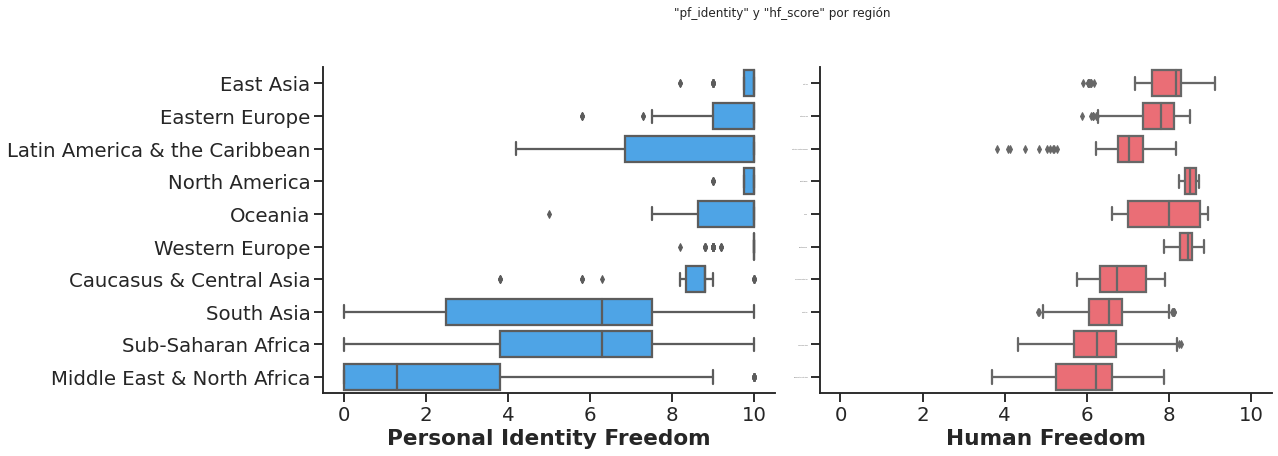

In [0]:
#Orden para plot, de mayor a menor, según la mediana de pf_identity
OrdReg = datasetNew.groupby('region').median().reset_index().sort_values('pf_identity',ascending=False)['region']

plt.figure(figsize=(17,6))

plt.suptitle('"pf_identity" y "hf_score" por región', y=1.02)
plt.subplots_adjust(wspace=0.1)
plt.subplot(1,2,1)
sns.boxplot(data=datasetNew,
            x='pf_identity', y='region', color=BLUE, order=OrdReg)
plt.xlabel('Personal Identity Freedom', weight='bold')
plt.ylabel('')
plt.xlim(-0.5,10.5)
sns.despine()

plt.subplot(1,2,2)
sns.boxplot(data=datasetNew,
            x='hf_score', y='region', color=RED, order=OrdReg)
plt.xlabel('Human Freedom', weight='bold')
plt.ylabel('')
plt.yticks(fontsize=0)
plt.xlim(-0.5,10.5)
sns.despine()

plt.show()

### ---Respuesta Nueva------------

Como puede observarse para ambos plots encontramos regiones con outliers, tanto para la variable **Human Freedom** como para **Personal Identity Freedom**. 
Si comparamos ambas variables podemos ver que para **Personal Identity Freedom** solo tenemos tres regiones que no poseen outliers, y para dos de ellas (*South Asia* y *Sub-Saharan Africa*) la dispersión de los datos practicamente toma todos los valores posibles sobre el rango (0-10).
Dentro de las regiones que presentan outliers para **Personal Identity Freedom**, *Caucasus & Central Asia* presenta la mayor cantidad porcentual de outliers (25.86% del total de sus datos) de todas las regiones.

Por otro lado, con respecto a la variable **Human Freedom** tenemos que el 50% de las regiones presentan outliers es decir que, a comparación de **Personal Identity Freedom** (donde el 70% de las regiones presentan outliers), pareciera que los outliers estan más concentrados en menos regiones. Así mismo, de las 5 regiones que presentan outliers 4 de ellas representan menos del 5% de sus datos, mientras que para *East Asia* los outlieres representan el 16.67% de los datos en su región.   

Realizando una evaluación en conjunto de las gráficas a nivel regional y a nivel global, podemos concretar que la remoción de outliers por región no generaría un impacto en los outliers globales.
A modo de ejemplo, por el plot anterior podemos observar que el menor valor de **Human Freedom** en el mundo pertenece a la región *Middle East & North Africa* (siendo este < 4, apreciable su el boxplot). Mientras que este valor **no** es un outlier a nivel regional, **si** lo es a nivel *Global* (visible en boxplot de **Human freedom** en el mundo).Esto nos da una idea de que la remoción de outliers no es necesaria en este caso. 
Además, creemos que estos outliers pueden poseer valor representativo real (no son errores de medición), ya que dentro de estas regiones es muy posible encontrar paises que presentan valores muy dispares entre los mismos.

Por último la presencia de outliers no afecta el tamaño del set de datos de forma significativa (en cuanto su impacto a tiempo de cómputo).
### ---Respuesta Vieja------------

Como se observa en el plot anterior, se presentan varios outliers a nivel **región**. A modo de ejeplo, *Caucasus & Central Asia* presenta la mayor cantidad porcentual de outliers (25.86% del su total) de todas las regiones.

Realizando una evaluación en conjunto de las gráficas a nivel regional y a nivel global, podemos concretar que la remoción de outliers por región no generaría un impacto en los outliers globales.
A modo de ejemplo, por el plot anterior podemos observar que el menor valor de *hf_score* en el mundo pertenece a la región *Middle East & North Africa* (siendo este < 4, apreciable su el boxplot). Mientras que este valor **no** es un outlier a nivel regional, **si** lo es a nivel Global (visible en boxplot de *hf_score* en el mundo) Esto nos da una idea de que la remoción de outliers no es necesaria en este caso. 

Además, creemos que estos outliers pueden poseer valor representativo real (no son errores de medición), y su presencia no afecta el tamaño del set de datos de forma significativa (en cuanto su impacto a tiempo de cómputo).

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

**2.1 Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.**

Graficamos la media de las variables *pf_identity* y *hf_score* a través de los años.

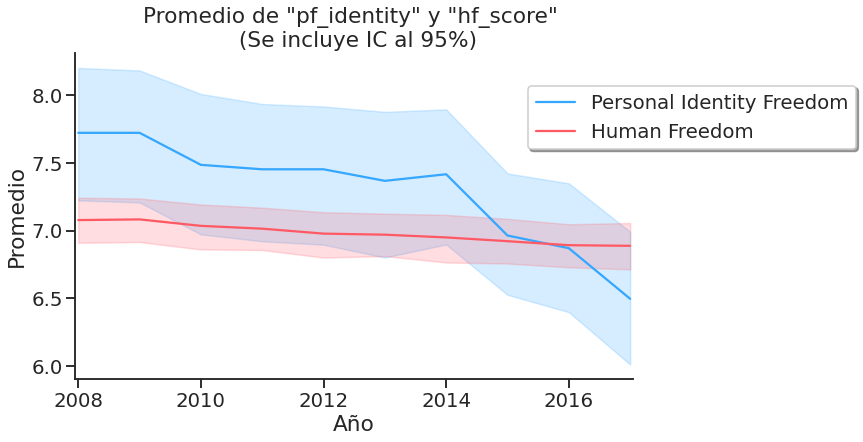

In [0]:
plt.figure(figsize=(10,6))
plt.title('Promedio de "pf_identity" y "hf_score" \n (Se incluye IC al 95%)')
sns.lineplot(data=datasetNew,
             estimator=np.mean, x='year', y='pf_identity', ci=95, label='Personal Identity Freedom', color=BLUE)
sns.lineplot(data=datasetNew,
             estimator=np.mean, x='year', y='hf_score', ci=95, label='Human Freedom', color=RED)

plt.xlabel('Año')
plt.ylabel('Promedio')
plt.legend(bbox_to_anchor=(1.4, 0.9), loc=0, borderaxespad=0, shadow=True)
plt.xlim(min(datasetNew.year)-0.05,max(datasetNew.year)+0.05)
sns.despine()

Se puede ver en el gráfico que ambas variables (*pf_identity* y *hf_score*) han disminuido su valor promedio a lo largo de los años, siendo el descenso del valor de la primera mayor que la segunda.

**2.2 Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?**

Veamos la evolución de ambas variables, discriminando por región.

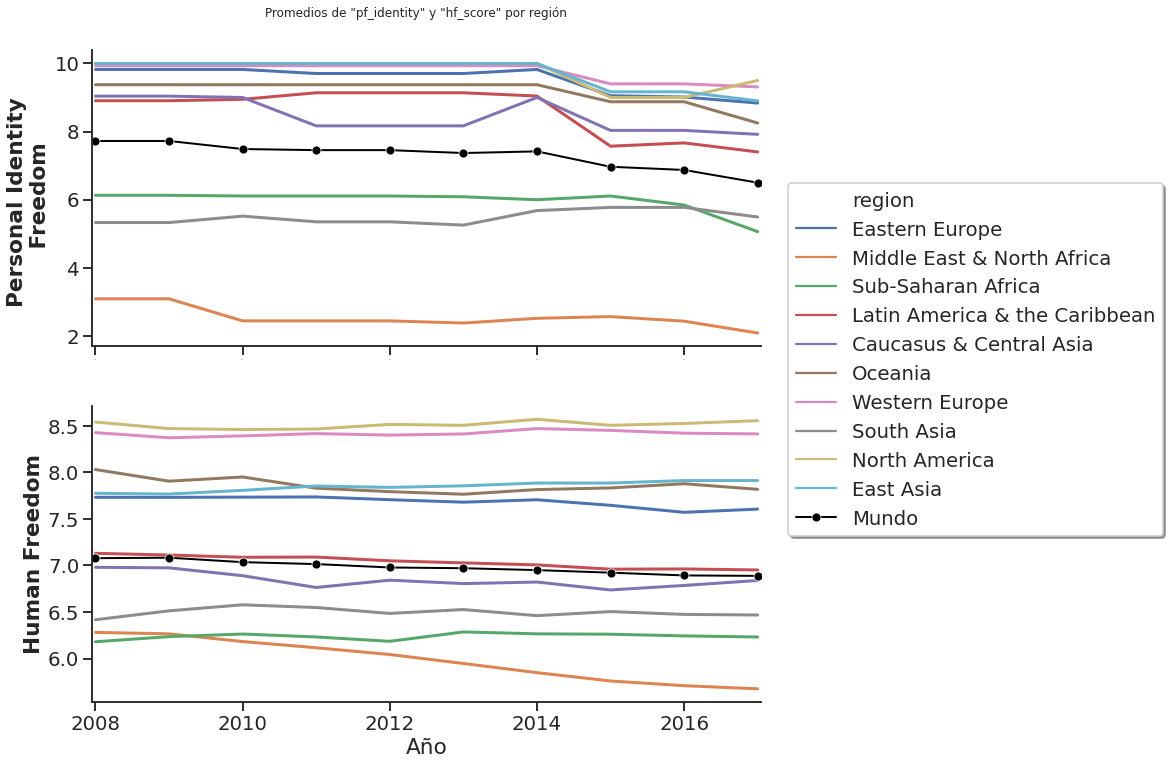

In [0]:
plt.figure(figsize=(12,12))

plt.suptitle('Promedios de "pf_identity" y "hf_score" por región', y=0.93)

plt.subplot(2,1,1)
sns.lineplot(data=datasetNew,
             estimator=np.mean, x='year', y='pf_identity', ci=None, lw=3, legend=None, hue='region',)
sns.lineplot(data=datasetNew,
             estimator=np.mean, x='year', y='pf_identity', ci=None, lw=2, legend=None, style='Todos', markers='o', color='black')

plt.xlabel('')
plt.ylabel('Personal Identity \n Freedom', weight='bold')
plt.xticks(fontsize=0)
plt.xlim(min(datasetNew.year)-0.05,max(datasetNew.year)+0.05)
sns.despine()

plt.subplot(2,1,2)
sns.lineplot(data=datasetNew,
             estimator=np.mean, x='year', y='hf_score', ci=None, lw=3, hue='region', legend='full')
sns.lineplot(data=datasetNew,
             estimator=np.mean, x='year', y='hf_score', ci=None, lw=2, style='Todos', legend=None,
             markers='o', label='Mundo', color='black')

plt.xlabel('Año')
plt.ylabel('Human Freedom', weight='bold')
plt.xlim(min(datasetNew.year)-0.05,max(datasetNew.year)+0.05)
plt.legend(bbox_to_anchor=(1.6, 1.75), loc=1, borderaxespad=0, shadow=True)
sns.despine()

plt.show()

### Respuesta Nueva
Es notable en el gráfico anterior la disminución de los valores de **Personal Identity Freedom** a través de los años y de forma casi sistemática. Podemos tratar como excepción a *South Asia* y a *North America*. En particular en *South Asia* si comparamos los valores del 2008 y del 2017 podemos observar la presencia de un leve incremento. Por otro lado en *North America* se observa en el ultimo año rompe con la tendencia aumentando su valor, sin embargo si tomamos en cuenta todos los años tambien presenta una disminución de sus valores. Esta tendencia, que se ve a partir del análisis de las *regiones*, se refleja en la disminución de los valores de la variable **Persona Identity Freedom** a nivel *global* a través de los años. 
Siguiendo con el analisís sobre la misma variable, también es destacable que solo hay tres regiones (*Middle East & North Africa*, *South Asia* y *Sub-Saharan Africa*) por debajo de la media *global*. En particular para la región *Middle East & North Africa* llama la atención los valores tan bajos que toma y que, por la tendencia, pareciera estar cada vez "peor".

En cuanto a los valores de **Human Freedom**, todas las regiones (excepto *Middle East & North Africa* la cual disminuye >~0.5 puntos en total) parecen mantener sus puntajes aproximadamente constante a lo largo de los años. Tambien podemos notar, que a diferencia de la variable **Personal Identity Freedom**, en este caso las regiones se ubican de forma mas equitativa por encima o por debajo del valor *global*.

### Respuesta Vieja

Es notable en el gráfico anterior la presencia de una disminución del valor de *pf_identity* en todas las regiones del Mundo (exceptuando las regiones de '*Sub-Saharan Africa*, *Middle East & North Africa*, y el *South Asia*)(**esto no entendí**), reflejando una disminución de su valor Global. También es destacable la diferencia de los valores promedio entre estas 3 últimas regiones y el resto, de tal forma que son las únicas debajo del promedio Global durante todos los años.

En cuanto al *hf_score*, todas las regiones (excepto *Middle East & North Africa* el cual disminuye >~0.5 puntos en total) parecen mantener su puntaje aproximadamente constante a lo largo de los años.

**2.3 Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable pf_identity en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?**

Veamos los valores de *pf_identity* y *hf_score* en países de Latinoamérica y el Caribe

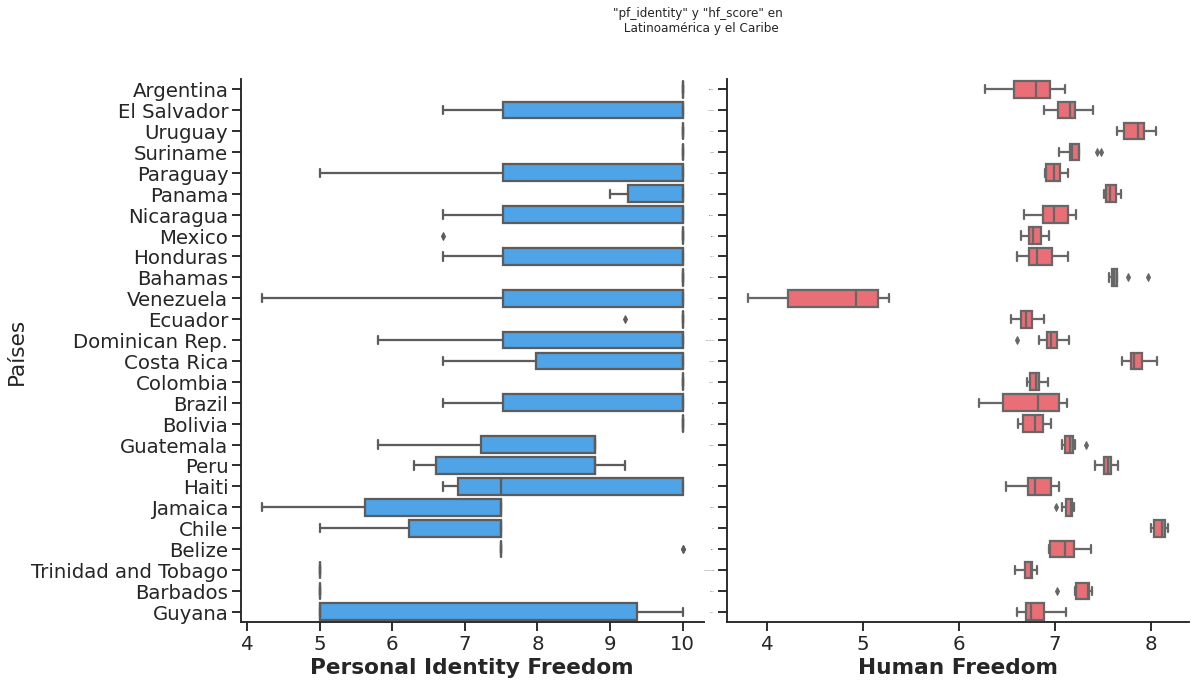

In [0]:
#Orden para plot, de mayor a menor, según pf_identity
OrdLat = datasetNew[LatAmyCnew].groupby('countries').median().reset_index().sort_values('pf_identity',ascending=False)['countries']

plt.figure(figsize=(17,10))
plt.subplots_adjust(wspace=0.05)
plt.suptitle('"pf_identity" y "hf_score" en \n Latinoamérica y el Caribe')

plt.subplot(1,2,1)
sns.boxplot(data=datasetNew[LatAmyCnew],
            x='pf_identity', y='countries', color=BLUE, order = OrdLat)
plt.xlabel('Personal Identity Freedom', weight='bold')
plt.ylabel('Países')
sns.despine(left=True)

plt.subplot(1,2,2)
sns.boxplot(data=datasetNew[LatAmyCnew],
            x='hf_score', y='countries', color=RED, order = OrdLat)
plt.xlabel('Human Freedom', weight='bold')
plt.yticks(fontsize=0)
plt.ylabel('')
sns.despine(left=False)

plt.show()

Seleccionamos 4 países de Latinomérica y el Caribe para analizar. 
Se seleccionaron: **Argentina** (donde vivimos), **Venezuela** (el peor H_F), **Chile** (el mejor H_F), **Guyana** (la mayor dispesión en Pi_F luego de Venezuela)

In [0]:
#Set de países de LatAmyC para observar
countriestest = ['Venezuela', 'Argentina', 'Chile', 'Guyana']

#Creamos una máscara del datasetNew de los países recién detallados
TestCountries = np.zeros((len(datasetNew)))
for pais in countriestest:
    TestCountries += datasetNew.countries == str(pais)
TestCountries = TestCountries == True

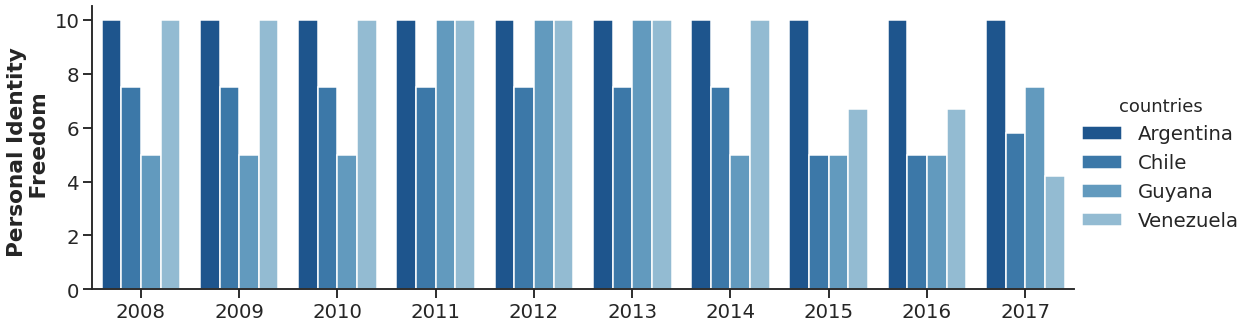

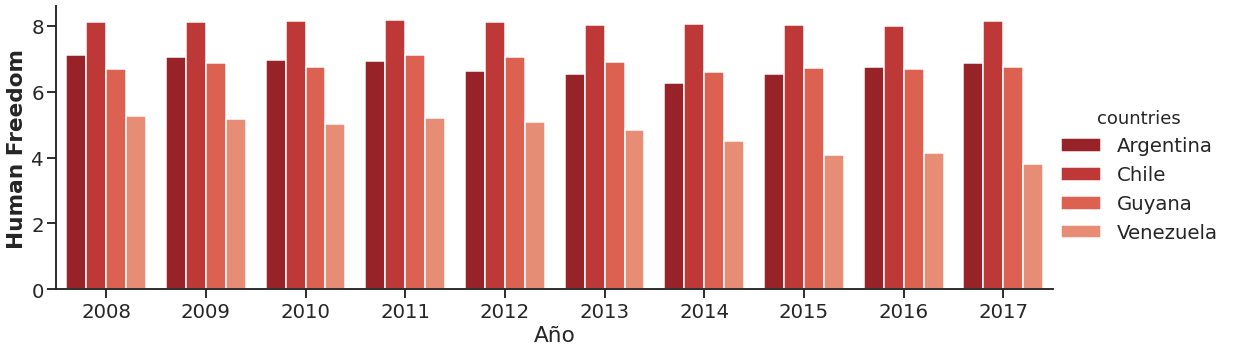

In [0]:
sns.catplot(x="year", y="pf_identity", hue='countries',
                data=datasetNew[TestCountries],  
                kind="bar", height=5, aspect=3, palette=sns.color_palette("Blues_r"))
plt.xlabel('')
plt.ylabel('Personal Identity \n Freedom', weight='bold')

sns.catplot(x="year", y="hf_score", hue='countries',
                data=datasetNew[TestCountries],  
                kind="bar", height=5, aspect=3, palette=sns.color_palette("Reds_r"))
plt.xlabel('Año')
plt.ylabel('Human Freedom', weight='bold')
plt.show()

En el plot anterior se puede ver que los valores de **Human Freedom** correspondientes a los 4 países seleccionados se mantienen aproximadamente estables (al igual que el comportamiento del valor correspondiente a toda *LatAm y el Caribe*).

Por otro lado, se puede observar también que al menos 3 de los 4 valores de **Personal Identity Freedom** de los países seleccionados se encuentran por encima del puntaje "6" durante los primeros 7 años; sin embargo en 2015 se produce un cambio de tal forma que de ahí en adelante solo 2 de los 4 superan ese valor. Esto de alguna forma refleja aproximadamente el comportamiento de disminución de valor de esta variable correspondiente a *LatAm y el Caribe* ese mismo año (y los siguientes).


Veamos la evolución las variables *ef_score* (**Economic Freedom Score**), *pf_score* (**Personal Freedom Score**), *hf_score* (**Human Freedom Score**) a lo largo de los años.

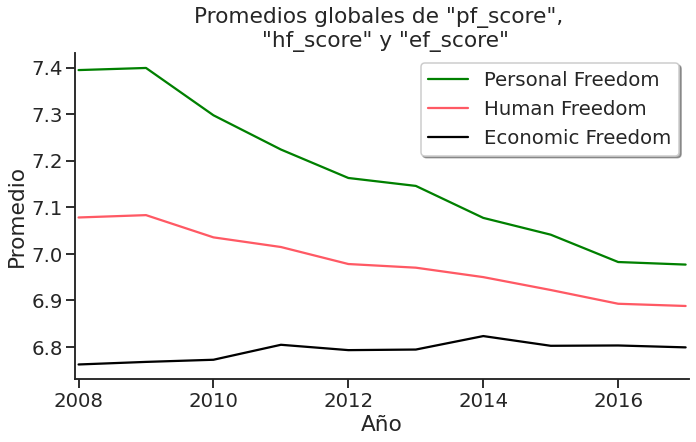

In [0]:
plt.figure(figsize=(11,6))
plt.title('Promedios globales de "pf_score", \n "hf_score" y "ef_score"')

sns.lineplot(data=datasetNew,
             estimator=np.mean, x='year', y='pf_score', ci=None, label='Personal Freedom', color='green')
sns.lineplot(data=datasetNew,
             estimator=np.mean, x='year', y='hf_score', ci=None, label='Human Freedom'   , color=RED)
sns.lineplot(data=datasetNew,
             estimator=np.mean, x='year', y='ef_score', ci=None, label='Economic Freedom', color='black')

plt.xlabel('Año')
plt.ylabel('Promedio')
plt.xlim(min(datasetNew.year)-0.05,max(datasetNew.year)+0.05)
sns.despine()

plt.legend(loc=0, shadow=True)

plt.show()

Sabiendo que *hf_score* es el promedio de *pf_score* y *ef_score*, se entiende que la evolución del promedio de estos 2 últimos se reflejarán en la evolución del primero.

El valor de *ef_score* ha aumentado a lo largo de los años, sin embargo como el valor de *pf_score* ha disminuído más (en valor absoluto) que el crecimiento del primero, esto se refleja en la disminución del valor de *hf_score* a lo largo del tiempo.

## 3. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos el conjunto de valores disponibles para esa region en estos gráficos?


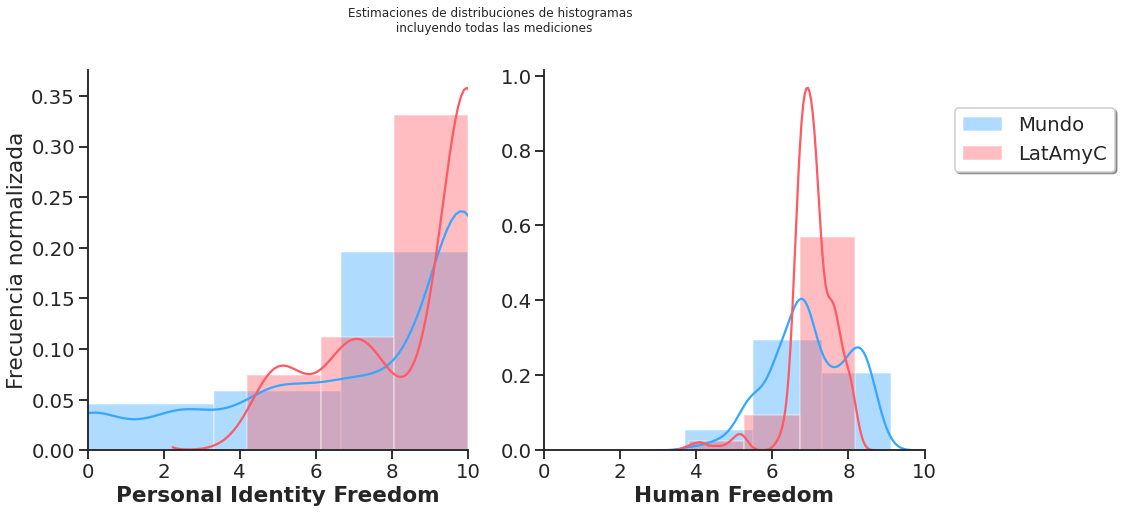

In [0]:
plt.figure(figsize=(15,7))
plt.suptitle('Estimaciones de distribuciones de histogramas \n incluyendo todas las mediciones', y=1.005)
bins=3 #Número de bins para histograma

plt.subplot(1,2,1)
sns.distplot(datasetNew.pf_identity,
             kde=True, norm_hist=True, bins=bins, color=BLUE)
sns.distplot(datasetNew.pf_identity[LatAmyCnew],
             kde=True, norm_hist=True, bins=bins, color=RED)

plt.xlabel('Personal Identity Freedom', weight='bold')
plt.ylabel('Frecuencia normalizada')
plt.xlim(0,10)
sns.despine()

plt.subplot(1,2,2)
sns.distplot(datasetNew.hf_score,
             kde=True, norm_hist=True, bins=bins, label='Mundo', color=BLUE)
sns.distplot(datasetNew.hf_score[LatAmyCnew],
             kde=True, norm_hist=True, bins=bins, label='LatAmyC', color=RED)
plt.xlabel('Human Freedom', weight='bold')
plt.ylabel('')
plt.xlim(0,10)
sns.despine()

plt.legend(bbox_to_anchor=(1.5, 0.9), loc=0, borderaxespad=0, shadow=True)

plt.show()

In [0]:
print('Propiedades de distribución de pf_identity')
print('LatAmyC:'
     '\n Media    : %.4f'
     '\n Desv Est : %.4f'
     '\n Asimetría: %.4f'
     '\n Kurtosis : %.4f' 
      %(datasetNew[LatAmyCnew].pf_identity.mean(),
        datasetNew[LatAmyCnew].pf_identity.std(),
        datasetNew[LatAmyCnew].pf_identity.skew(),
        datasetNew[LatAmyCnew].pf_identity.kurt()))
print('Mundo:'
     '\n Media    : %.4f'
     '\n Desv Est : %.4f'
     '\n Asimetría: %.4f'
     '\n Kurtosis : %.4f' 
      %(datasetNew.pf_identity.mean(),
        datasetNew.pf_identity.std(),
        datasetNew.pf_identity.skew(),
        datasetNew.pf_identity.kurt()))
print('')
print('Propiedades de distribución de hf_score')
print('LatAmyC:'
     '\n Media    : %.4f'
     '\n Desv Est : %.4f'
     '\n Asimetría: %.4f'
     '\n Kurtosis : %.4f' 
      %(datasetNew[LatAmyCnew].hf_score.mean(),
        datasetNew[LatAmyCnew].hf_score.std(),
        datasetNew[LatAmyCnew].hf_score.skew(),
        datasetNew[LatAmyCnew].hf_score.kurt()))
print('Mundo:'
     '\n Media    : %.4f'
     '\n Desv Est : %.4f'
     '\n Asimetría: %.4f'
     '\n Kurtosis : %.4f' 
      %(datasetNew.hf_score.mean(),
        datasetNew.hf_score.std(),
        datasetNew.hf_score.skew(),
        datasetNew.hf_score.kurt()))

Propiedades de distribución de pf_identity
LatAmyC:
 Media    : 8.5822
 Desv Est : 1.8758
 Asimetría: -0.8883
 Kurtosis : -0.7465
Mundo:
 Media    : 7.2806
 Desv Est : 3.1816
 Asimetría: -0.9718
 Kurtosis : -0.2834

Propiedades de distribución de hf_score
LatAmyC:
 Media    : 7.0370
 Desv Est : 0.6349
 Asimetría: -1.8386
 Kurtosis : 7.1277
Mundo:
 Media    : 6.9782
 Desv Est : 1.0562
 Asimetría: -0.2061
 Kurtosis : -0.4927


Ninguna de las distribuciones presentadas en el gráfico anterior parece reconocible ("teórica").

Para la distribución de *pf_identity*, se observa una distribucion con asimetría negativa, reafirmando lo comentado en el punto **1** (cuando calculamos que la *media* es menor a la *mediana* tanto a nivel 'Global' como a nivel 'Latinoamérica y el Caribe').

Por otro lado, para la distribución de *hf_score* también se observa una distribucion con asimetría negativa, pero en este caso mucho más pronunciada para 'Latinoamérica y el Caribe' que a nivel 'Global'.

Es notable como el valor para el pico de las distribuciones de las variables en contexto 'Global' son casi idénticas a los picos en 'Latinoamérica y el Caribe'.

Debido a que, de acuerdo al gráfico anterior en cuanto a **Personal Identity Freedom** en *LatAm y el Caribe*, cerca del 70% de los estos valores se encuentran en el rango (8, 10), nos hace pensar que podríamos concentrarnos en menos realizaciones sin tener un impacto significativo importante en los resultados.

## 4. Correlaciones y Relaciones

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.



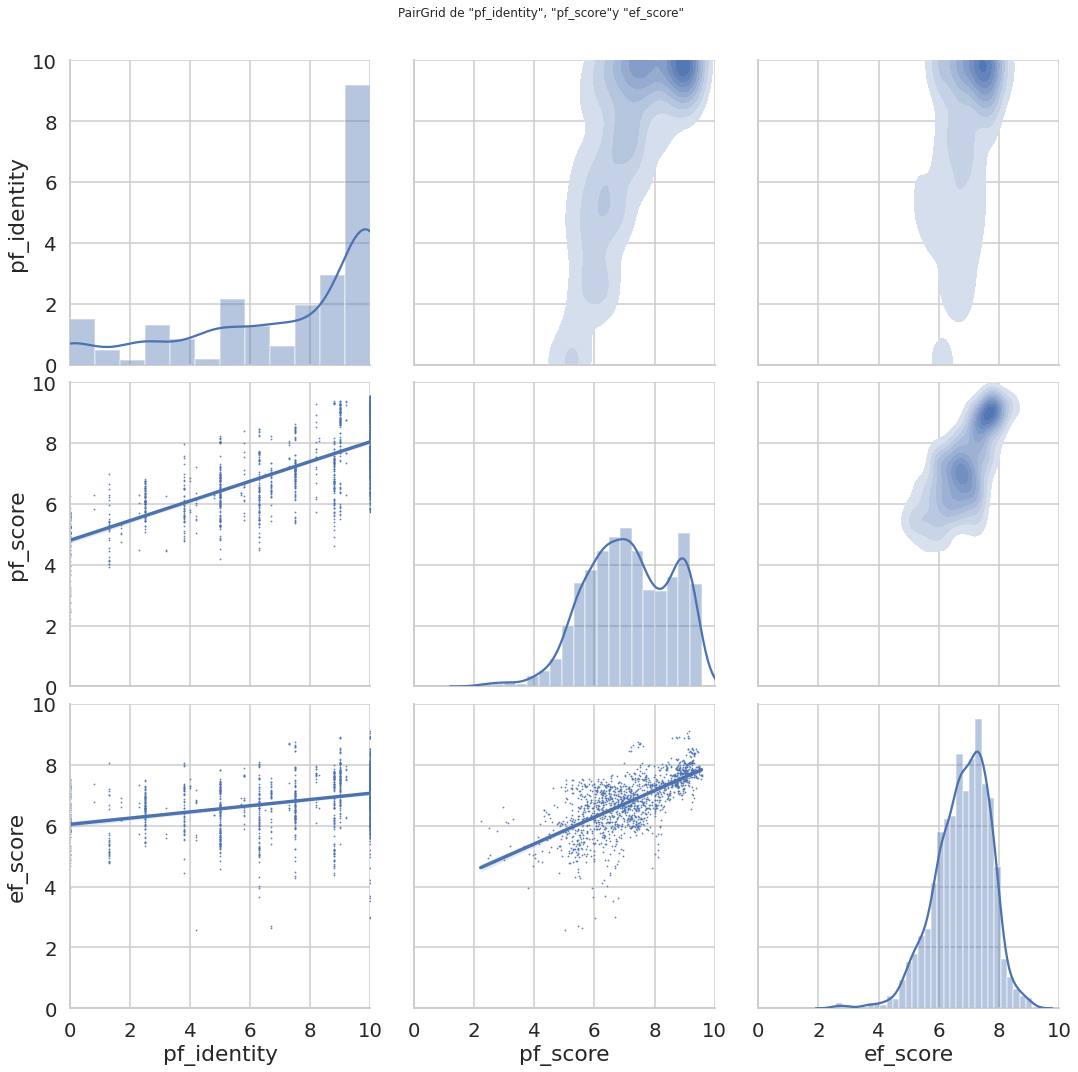

In [0]:
with sns.axes_style("whitegrid"):
    g = sns.PairGrid(data=datasetNew, vars=['pf_identity', 'pf_score', 'ef_score'], height=5, aspect=1)
    g.set(xlim=(0, 10))
    g.set(ylim=(0, 10))
    g.map_lower(sns.regplot, ci=95, scatter_kws={"s": 0.7}) #Intervalo de Confianza = 95%
    g.map_diag (sns.distplot, kde=True, norm_hist=True)
    g.map_upper(sns.kdeplot, n_levels=10, shade=True, shade_lowest=False)

plt.subplots_adjust(top=0.93)
g.fig.suptitle('PairGrid de "pf_identity", "pf_score"y "ef_score"')

plt.show()

In [0]:
#AJUSTE. Método 1

#Realizamos un pequeño ajute lineal para los 3 distplot presentados
pfsc_efsc_Coe, pfsc_efsc_Var = np.polyfit(datasetNew.pf_score   , datasetNew.ef_score, deg = 1, cov=True)
pfid_pfsc_Coe, pfid_pfsc_Var = np.polyfit(datasetNew.pf_identity, datasetNew.pf_score, deg = 1, cov=True)
pfid_efsc_Coe, pfid_efsc_Var = np.polyfit(datasetNew.pf_identity, datasetNew.ef_score, deg = 1, cov=True)

#Vemos los valores obtenidos
print('Resultados de ajustes lineales producidos [a*x + b]:'), print('')
print('Personal Freedom Score & Economic Freedom Score:'
       '\n a = %.4f +- %.4f == %.2f%%'
       '\n b = %.4f +- %.4f == %.2f%%'
       %(pfsc_efsc_Coe[0], np.sqrt(pfsc_efsc_Var[0,0]), np.sqrt(pfsc_efsc_Var[0,0])*100/pfsc_efsc_Coe[0],
         pfsc_efsc_Coe[1], np.sqrt(pfsc_efsc_Var[1,1]), np.sqrt(pfsc_efsc_Var[1,1])*100/pfsc_efsc_Coe[1])
       ), print('')
print('Personal Identity Freedom & Personal Freedom Score:'
       '\n a = %.4f +- %.4f == %.2f%%'
       '\n b = %.4f +- %.4f == %.2f%%'
       %(pfid_pfsc_Coe[0], np.sqrt(pfid_pfsc_Var[0,0]), np.sqrt(pfid_pfsc_Var[0,0])*100/pfid_pfsc_Coe[0],
         pfid_pfsc_Coe[1], np.sqrt(pfid_pfsc_Var[1,1]), np.sqrt(pfid_pfsc_Var[1,1])*100/pfid_pfsc_Coe[1])
       ), print('')
print('Personal Identity Freedom & Economic Freedom Score:'
       '\n a = %.4f +- %.4f == %.2f%%'
       '\n b = %.4f +- %.4f == %.2f%%'
       %(pfid_efsc_Coe[0], np.sqrt(pfid_efsc_Var[0,0]), np.sqrt(pfid_efsc_Var[0,0])*100/pfid_efsc_Coe[0],
         pfid_efsc_Coe[1], np.sqrt(pfid_efsc_Var[1,1]), np.sqrt(pfid_efsc_Var[1,1])*100/pfid_efsc_Coe[1])
       )

Resultados de ajustes lineales producidos [a*x + b]:

Personal Freedom Score & Economic Freedom Score:
 a = 0.4387 +- 0.0123 == 2.80%
 b = 3.6502 +- 0.0896 == 2.45%

Personal Identity Freedom & Personal Freedom Score:
 a = 0.3248 +- 0.0075 == 2.30%
 b = 4.7985 +- 0.0594 == 1.24%

Personal Identity Freedom & Economic Freedom Score:
 a = 0.1024 +- 0.0068 == 6.63%
 b = 6.0477 +- 0.0539 == 0.89%


In [0]:
#AJUSTE. Método 2
slope1, intercep1, r_value1, p_value1, std_err1 = sp.stats.linregress(datasetNew.pf_score   , datasetNew.ef_score)
slope2, intercep2, r_value2, p_value2, std_err2 = sp.stats.linregress(datasetNew.pf_identity, datasetNew.pf_score)
slope3, intercep3, r_value3, p_value3, std_err3 = sp.stats.linregress(datasetNew.pf_identity, datasetNew.ef_score)

#Vemos los valores obtenidos
print('Resultados de ajustes lineales producidos [a*x + b]:'), print('')
print('Personal Freedom Score & Economic Freedom Score:'
       '\n a  = %.4f +- %.4f == %.2f%%'
       '\n b  = %.4f'
       '\n r² = %.4f'
       %(slope1, std_err1, std_err1*100/slope1,
         intercep1,
         r_value1**2)
       ), print('')
print('Personal Identity Freedom & Personal Freedom Score:'
       '\n a  = %.4f +- %.4f == %.2f%%'
       '\n b  = %.4f'
       '\n r² = %.4f'
       %(slope2, std_err2, std_err2*100/slope2,
         intercep2,
         r_value2**2)
       ), print('')
print('Personal Identity Freedom & Economic Freedom Score:'
       '\n a  = %.4f +- %.4f == %.2f%%'
       '\n b  = %.4f'
       '\n r² = %.4f'
       %(slope3, std_err3, std_err3*100/slope3,
         intercep3,
         r_value3**2)
       )

Resultados de ajustes lineales producidos [a*x + b]:

Personal Freedom Score & Economic Freedom Score:
 a  = 0.4387 +- 0.0123 == 2.80%
 b  = 3.6502
 r² = 0.4538

Personal Identity Freedom & Personal Freedom Score:
 a  = 0.3248 +- 0.0075 == 2.30%
 b  = 4.7985
 r² = 0.5509

Personal Identity Freedom & Economic Freedom Score:
 a  = 0.1024 +- 0.0068 == 6.63%
 b  = 6.0477
 r² = 0.1290


3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.

In [0]:
#Hacemos un binneado por cuartiles de las variables a estudiar.
#Para pf_identity, se tiene que utilar un quartil extra para que no haya binnes duplicados (Se puede ver en el boxplot que el 4to cuartil es igual al 3ro)

pf_identity_segment, pf_identity_segment_bins  = pd.qcut(datasetNew.pf_identity, q=4, duplicates='drop',
                                                         labels=["Low", "Medium", "High"], retbins = True) #pf_identity
pf_score_segment   , pf_score_segment_bins     = pd.qcut(datasetNew.pf_score   , q=3, duplicates='drop',
                                                         labels=["Low", "Medium", "High"], retbins = True) #pf_score
ef_score_segment   , ef_score_segment_bins     = pd.qcut(datasetNew.ef_score   , q=3, duplicates='drop',
                                                         labels=["Low", "Medium", "High"], retbins = True) #ef_score

4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.


In [0]:
#Creamos datos para HeatMap1
pf_identity_pf_score_data = pd.concat([pf_identity_segment, pf_score_segment], axis = 1)
pf_identity_pf_score_data = pf_identity_pf_score_data.groupby(['pf_identity','pf_score']).size().reset_index(name='counts').pivot('pf_identity', 'pf_score', 'counts')

#Creamos datos para HeatMap2
pf_identity_ef_score_data = pd.concat([pf_identity_segment, ef_score_segment], axis = 1)
pf_identity_ef_score_data = pf_identity_ef_score_data.groupby(['pf_identity','ef_score']).size().reset_index(name='counts').pivot('pf_identity', 'ef_score', 'counts')

#Creamos datos para HeatMap3
pf_score_ef_score_data    = pd.concat([pf_score_segment, ef_score_segment], axis = 1)
pf_score_ef_score_data    = pf_score_ef_score_data.groupby(['pf_score','ef_score']).size().reset_index(name='counts').pivot('pf_score', 'ef_score', 'counts')


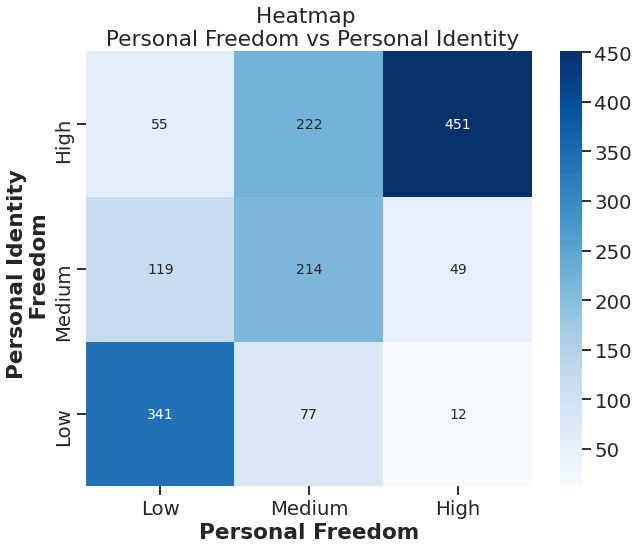

In [0]:
plt.figure(figsize=(10,8))
hm01 = sns.heatmap(pf_identity_pf_score_data, annot=True, fmt='d', annot_kws={"size":14}, cmap="Blues")
hm01.invert_yaxis()
plt.title("Heatmap \n Personal Freedom vs Personal Identity")
plt.xlabel("Personal Freedom", weight='bold')
plt.ylabel("Personal Identity \n Freedom", weight='bold')
plt.show()

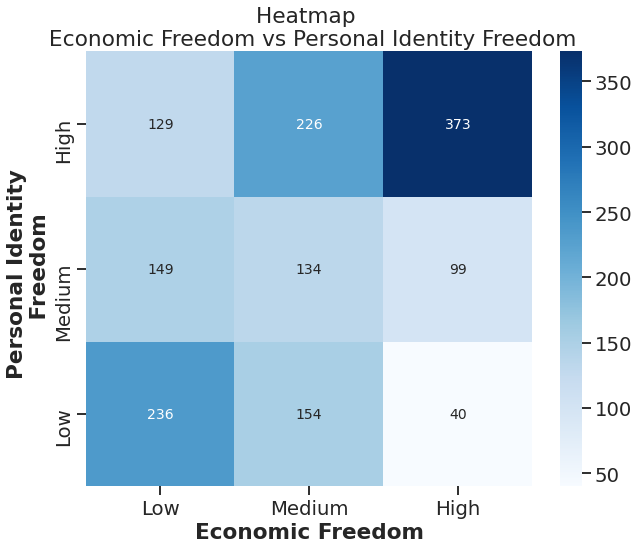

In [0]:
plt.figure(figsize=(10,8))
hm02 = sns.heatmap(pf_identity_ef_score_data, annot=True, fmt='d', annot_kws={"size":14}, cmap="Blues")
hm02.invert_yaxis()
plt.title("Heatmap \n Economic Freedom vs Personal Identity Freedom")
plt.xlabel("Economic Freedom", weight='bold')
plt.ylabel("Personal Identity \n Freedom", weight='bold')
plt.show()

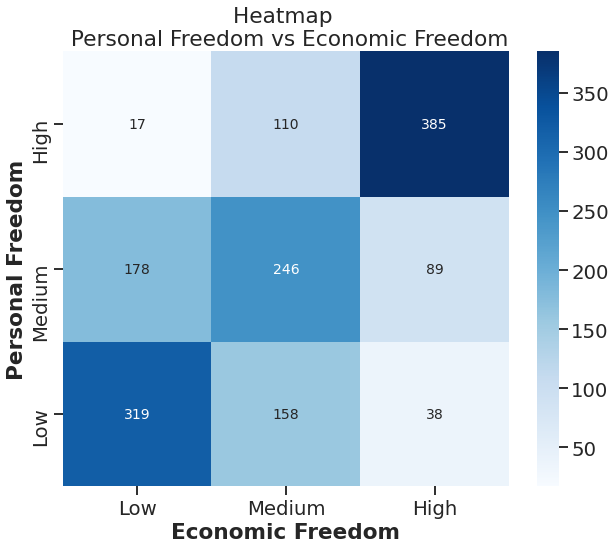

In [0]:
plt.figure(figsize=(10,8))
hm02 = sns.heatmap(pf_score_ef_score_data, annot=True, fmt='d', annot_kws={"size":14},cmap="Blues")
hm02.invert_yaxis()
plt.title("Heatmap \n Personal Freedom vs Economic Freedom")
plt.xlabel("Economic Freedom", weight='bold')
plt.ylabel("Personal Freedom", weight='bold')
plt.show()

# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

1. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

Aunque ninguna de las distribuciones generadas se asemeja a algo conocido, realizaremos un test de hipótesis para comparar la distribución de Human Freedom Score *LatAm y el Caribe* y Economic Freedom *Global* con una gaussiana.

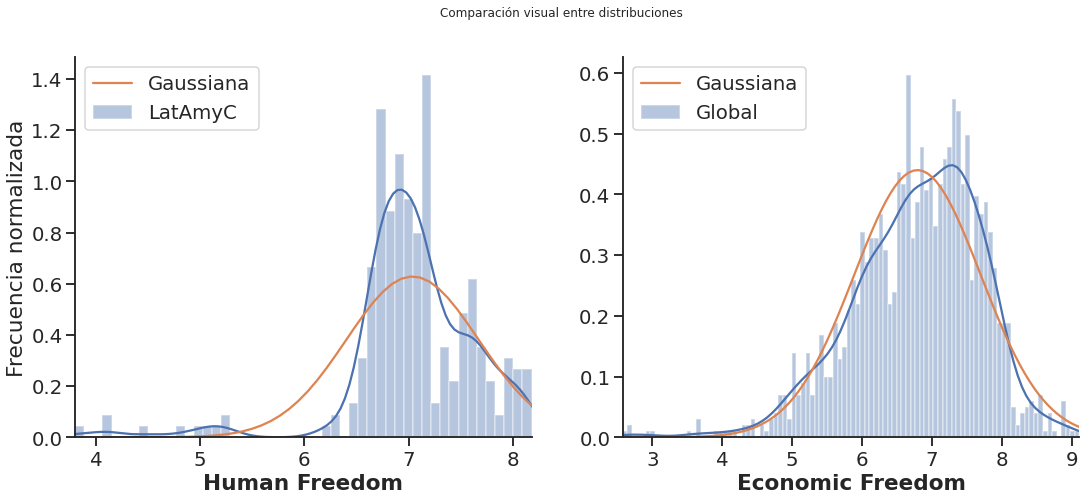

In [0]:
#Ploteamos para comparar visualmente
bins_pf=50  #Bines para pf_identity
bins_ef=100 #Bines para ef_score

plt.figure(figsize=(18,7))
plt.suptitle('Comparación visual entre distribuciones')

plt.subplot(1,2,1)
sns.distplot(datasetNew[LatAmyCnew].hf_score, kde=True, norm_hist=True, bins=bins_pf, label='LatAmyC')
sns.lineplot(np.linspace(min(datasetNew[LatAmyCnew].hf_score), max(datasetNew[LatAmyCnew].hf_score), bins_pf),
             sp.stats.norm.pdf(np.linspace(min(datasetNew[LatAmyCnew].hf_score), max(datasetNew[LatAmyCnew].hf_score), bins_pf),
                               datasetNew[LatAmyCnew].hf_score.mean(), datasetNew[LatAmyCnew].hf_score.std()), label='Gaussiana')

plt.xlabel('Human Freedom', weight='bold')
plt.ylabel('Frecuencia normalizada')
plt.xlim(min(datasetNew[LatAmyCnew].hf_score), max(datasetNew[LatAmyCnew].hf_score))
sns.despine()

plt.subplot(1,2,2)
sns.distplot(datasetNew.ef_score, kde=True, norm_hist=True, bins=bins_ef, label='Global')
sns.lineplot(np.linspace(min( datasetNew.ef_score), max(datasetNew.ef_score), bins_ef),
             sp.stats.norm.pdf(np.linspace(min(datasetNew.ef_score), max(datasetNew.ef_score), bins_ef),
                                datasetNew.ef_score.mean(), datasetNew.ef_score.std()), label='Gaussiana')

plt.xlabel('Economic Freedom', weight='bold')
plt.ylabel('')
plt.xlim(min(datasetNew.ef_score), max(datasetNew.ef_score))
sns.despine()

plt.show()

In [0]:
#Planteamos la primer hipótesis nula
print('Hipótesis nula: La distribución de Human Freedom de Latinoamérica y el Caribe es Gaussiana con: '
      '\n mu    = %.3f'
      '\n sigma = %.3f'
      %(datasetNew[LatAmyCnew].hf_score.mean(), datasetNew[LatAmyCnew].hf_score.std())), print('')

#Para realizar el ks_test, se normalizan los datos: (x-mu)/sigma), para luego comparar con una distribución normal.
hf_LAC_normed = (datasetNew[LatAmyCnew].hf_score - datasetNew[LatAmyCnew].hf_score.mean())/datasetNew[LatAmyCnew].hf_score.std()

#Nivel de significancia
alpha_hf = 0.05
print('Definimos un nivel de significancia:'
      '\n alpha =', alpha_hf), print('')

#Realizamos el ks_test
_, pvalue_hf = sp.stats.kstest(hf_LAC_normed, 'norm')
print('Realizamos el estadístico de prueba ks_test:'
     '\n pvalue = %f' %pvalue_hf), print('')

#Vemos los resultados
if (alpha_hf>pvalue_hf):
    print('Se rechaza la hipótesis nula con el nivel de significancia impuesto.')
else:
    print('No se puede rechazar la hipótesis nula con el nivel de significancia impuesto.') 

Hipótesis nula: La distribución de Human Freedom de Latinoamérica y el Caribe es Gaussiana con: 
 mu    = 7.037
 sigma = 0.635

Definimos un nivel de significancia:
 alpha = 0.05

Realizamos el estadístico de prueba ks_test:
 pvalue = 0.000001

Se rechaza la hipótesis nula con el nivel de significancia impuesto.


In [0]:
#Planteamos la hipótesis nula
print('Hipótesis nula: La distribución de Economic Freedom del Mundo es Gaussiana con: '
      '\n mu    = %.3f'
      '\n sigma = %.3f'
      %(datasetNew.ef_score.mean(), datasetNew.ef_score.std())), print('')

#Para realizar el ks_test, se normalizan los datos: (x-mu)/sigma), para luego comparar con una distribución normal.
ef_normed = (datasetNew.ef_score - datasetNew.ef_score.mean())/datasetNew.ef_score.std()

#Nivel de significancia
alpha_ef = 0.05
print('Definimos un nivel de significancia:'
      '\n alpha =', alpha_ef), print('')

#Realizamos el ks_test
_, pvalue_ef = sp.stats.kstest(ef_normed, 'norm')
print('Realizamos el estadístico de prueba ks_test:'
     '\n pvalue = %f' %pvalue_ef), print('')

#Vemos los resultados
if (alpha_ef>pvalue_ef):
    print('Se rechaza la hipótesis nula con el nivel de significancia impuesto.')
else:
    print('No se puede rechazar la hipótesis nula con el nivel de significancia impuesto.')  

Hipótesis nula: La distribución de Economic Freedom del Mundo es Gaussiana con: 
 mu    = 6.793
 sigma = 0.907

Definimos un nivel de significancia:
 alpha = 0.05

Realizamos el estadístico de prueba ks_test:
 pvalue = 0.000709

Se rechaza la hipótesis nula con el nivel de significancia impuesto.


Como se puede  observar en los resultados recién obtenidos al realizar los test de Kolmogorov-Smirnof correspondientes, ninguna de las 2 variables seleccionadas (**Personal Identity Freedom** y **Economic Freedom**) poseen distribución gaussiana (para el nivel de significancia impuesto ($\alpha=0.05$))

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no.

Por tratarse de dos variables cuantitativas y no ordinales me parece lo mas adecuado utilizar el coeficiente de correlacion de Pearson para evaluar el tipo de relacion entre las variables.

In [0]:
print('Coeficientes de correlación entre variables:'), print('')
print('pf_identity y pf_score:'
      '\n Pearson  : %.4f'
      '\n Spearman : %.4f'
      % (datasetNew.corr(method="pearson")["pf_identity"]["pf_score"],
         datasetNew.corr(method="spearman")["pf_identity"]["pf_score"]))
print('')
print('pf_identity y ef_score:'
      '\n Pearson  : %.4f'
      '\n Spearman : %.4f'
      % (datasetNew.corr(method="pearson")["pf_identity"]["ef_score"],
         datasetNew.corr(method="spearman")["pf_identity"]["ef_score"]))
print('')
print('pf_score y ef_score:'
      '\n Pearson  : %.4f'
      '\n Spearman : %.4f'
      % (datasetNew.corr(method="pearson")["pf_score"]["ef_score"],
         datasetNew.corr(method="spearman")["pf_score"]["ef_score"]))
print('')
print('hf_score y ef_score:'
      '\n Pearson  : %.4f'
      '\n Spearman : %.4f'
      % (datasetNew.corr(method="pearson")["hf_score"]["ef_score"],
         datasetNew.corr(method="spearman")["hf_score"]["ef_score"]))
print('')
print('hf_score y pf_score:'
      '\n Pearson  : %.4f'
      '\n Spearman : %.4f'
      % (datasetNew.corr(method="pearson")["hf_score"]["pf_score"],
         datasetNew.corr(method="spearman")["hf_score"]["pf_score"]))
print('')
print('hf_score y pf_identity:'
      '\n Pearson  : %.4f'
      '\n Spearman : %.4f'
      % (datasetNew.corr(method="pearson")["hf_score"]["pf_identity"],
         datasetNew.corr(method="spearman")["hf_score"]["pf_identity"]))

Coeficientes de correlación entre variables:

pf_identity y pf_score:
 Pearson  : 0.7422
 Spearman : 0.7314

pf_identity y ef_score:
 Pearson  : 0.3592
 Spearman : 0.4008

pf_score y ef_score:
 Pearson  : 0.6737
 Spearman : 0.7107

hf_score y ef_score:
 Pearson  : 0.8733
 Spearman : 0.8807

hf_score y pf_score:
 Pearson  : 0.9483
 Spearman : 0.9512

hf_score y pf_identity:
 Pearson  : 0.6434
 Spearman : 0.6493


El valor del coeficiente indica una correlacion alta y al ser positiva esta indicando que ambas variables crecen y decrecen conjuntamente.
(Agrego tambien el coeficiente de Spearman por las dudas, dan muy parecido)

4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?